# Projet 8 : Déployez un modèle dans le cloud

Ce notebook a pour objectif de développer dans un environnement Big Data une première chaîne de traitement des données qui comprend le preprocessing et une étape de réduction de dimension. L'architecture Big Data doit permettre le passage à l’échelle avec des données massives. Une classification supervisée rapide est également implémentée.

Le notebook est organisé de la manière suivante :

* [**1. Prétraitement**](#1.-Prétraitement)
  * [**1.1 Configuration de Spark**](#1.1-Configuration-de-Spark)
  * [**1.2 Import des images**](#1.2-Import-des-images)
  * [**1.3 Extraction de features par le Transfer Learning**](#1.3-Extraction-de-features-par-le-Transfer-Learning)
* [**2. Réduction de dimension**](#2.-Réduction-de-dimension)
  * [**2.1 Prétraitement des données**](#2.1-Prétraitement-des-données)
    * [**2.1.1 Vectorisation**](#2.1.1-Vectorisation)
    * [**2.1.2 Standardisation**](#2.1.2-Standardisation)
  * [**2.2 Analyse en composantes principales ou ACP**](#2.2-Analyse-en-composantes-principales-ou-ACP)
  * [**2.3 Export et sauvegarde du résultat de la réduction de dimension**](#2.3-Export-et-sauvegarde-du-résultat-de-la-réduction-de-dimension)
* [**Conclusion**](#Conclusion)

In [1]:
# Project 8: Deploy a model in the cloud
# Import libraries
import os
import logging
import warnings
import pandas as pd
%pylab inline
import seaborn as sns
# import time

# I/O library
import io

# Import PySpark
import pyspark
import findspark
findspark.init()
findspark.find()

# Image processing librairies
from PIL import Image

# CNN (Convolutional Neural Network) Transfer learning libraries
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Pyspark library
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, udf, pandas_udf, PandasUDFType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StringIndexer, StandardScaler, PCA

# I/O library
from io import StringIO

# Disable WARNING, INFO and DEBUG logging everywhere
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.WARNING)
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(os.environ['PYSPARK_PYTHON'])

/home/ubuntu/anaconda3/bin/python


In [3]:
pyspark.__version__

'3.0.3'

# 1. Prétraitement

- Les caractéristiques de l'instance EC2 sélectionnées :
  - Le modèle : Ubuntu Server 20.04 LTS ;
  - Le type : t3a large ;
  - La RAM : 8 Go ;
  - Capacité de stockage : 30 Go.
- Pour évaluer à l'avance les besoins, il est possible de réaliser des tests dans un environnement de développement (pour analyser les limites des systèmes) avec une distribution Linux gratuite (machine virtuelle Ubuntu pour les utilisateurs de Windows).
- La librairie (kit SDK AWS) "Boto3" permet de créer, de configurer et de gérer les services AWS.
- L’architecture Big Data est composée de 3 services :
  - Le service S3 (Simple Storage Service) sert à stocker les données.
  - Le service EC2 (Elastic Compute Cloud) est le serveur qui permet de faire les calculs.
  - Le service IAM (Identity and Access Management) permet de gérer les utilisateurs.

## 1.1 Configuration de Spark

- Spark est un framework open source de calcul distribué (parallélisation des calculs) pour le traitement des données massives :
  - Le module "findspark" permet de localiser Spark sur le serveur EC2.
  - Un SparkContext gère les propriétés globales de l'application Spark telles que le niveau de logging, le niveau de parallélisation par défaut, etc.
- Hadoop est un framework logiciel dédié au stockage et au traitement de larges volumes de données :
  - L’ordonnancement des traitements.
  - La localisation des fichiers.
  - La distribution de l’exécution sur les noeuds.
- PySpark est une interface pour Apache Spark en Python qui par défaut utilise scala.

In [4]:
# 1. Preprocessing
# 1.1 Spark configuration
# Creating the SparkSession
spark = (SparkSession
         .builder.master('local[*]')
         .appName('p8_cloud_bigdata_aws')
         .getOrCreate())

# Instantiate SparkContext
sc = spark.sparkContext

# Adjust logging level
sc.setLogLevel('ERROR')

22/05/30 19:03:34 WARN Utils: Your hostname, ubuntu-2204 resolves to a loopback address: 127.0.1.1; using 192.168.253.131 instead (on interface ens33)
22/05/30 19:03:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/05/30 19:03:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
# Enabling Arrow-based columnar data transfers
# Enabling for Conversion to/from Pandas
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [6]:
# Displaying the SpakSession information
spark

## 1.2 Import des images

Nous commençons par charger les images dans un Spark dataframe.

In [7]:
# 1.2 Loading images in a Spark dataframe
categories_path = '/home/user/code/fruits-360-original-size/Training/'
categories = os.listdir(categories_path)
for i in range(len(categories)):
    pictures_path = categories_path + categories[i] + '/'
    category_df = spark.read.format(
        'binaryFile').option(
        'pathGlobFilter', '*.jpg').option(
        'recursiveFileLookup', 'true').load(pictures_path, inferschema=True)
    if i == 0:
        images_df = category_df
    else:
        images_df = images_df.union(category_df)
images_df = images_df.select('path', 'length', 'content')
print(images_df.count())
images_df.show(10)

6231
+--------------------+------+--------------------+
|                path|length|             content|
+--------------------+------+--------------------+
|file:/home/ubuntu...| 73525|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...| 72437|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...| 72084|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...| 71996|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...| 71903|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...| 71876|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...| 71687|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...| 71686|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...| 71660|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...| 71610|[FF D8 FF E0 00 1...|
+--------------------+------+--------------------+
only showing top 10 rows



Nous sélectionnons ensuite les colonnes pertinentes.

In [8]:
# Selection of relevant columns of the dataframe
images_df = images_df.withColumn(
    'category', split(col('path'), '/').getItem(6))
images_df = images_df.select('path', 'content', 'category')
images_df.show(10)

+--------------------+--------------------+----------+
|                path|             content|  category|
+--------------------+--------------------+----------+
|file:/home/ubuntu...|[FF D8 FF E0 00 1...|cucumber_3|
|file:/home/ubuntu...|[FF D8 FF E0 00 1...|cucumber_3|
|file:/home/ubuntu...|[FF D8 FF E0 00 1...|cucumber_3|
|file:/home/ubuntu...|[FF D8 FF E0 00 1...|cucumber_3|
|file:/home/ubuntu...|[FF D8 FF E0 00 1...|cucumber_3|
|file:/home/ubuntu...|[FF D8 FF E0 00 1...|cucumber_3|
|file:/home/ubuntu...|[FF D8 FF E0 00 1...|cucumber_3|
|file:/home/ubuntu...|[FF D8 FF E0 00 1...|cucumber_3|
|file:/home/ubuntu...|[FF D8 FF E0 00 1...|cucumber_3|
|file:/home/ubuntu...|[FF D8 FF E0 00 1...|cucumber_3|
+--------------------+--------------------+----------+
only showing top 10 rows



## 1.3 Extraction de features par le Transfer Learning

Nous allons ensuite effectuer l'extraction de features par le Transfer Learning. On commence par charger un algorithme de type réseaux de neurones convolutifs (CNN). Il existe plusieurs modèles pré-entraînés (ResNet50, VGG16, EfficientNetB7, etc.), il faut donc sélectionner le modèle le plus adapté à la tâche à effectuer. Le modèle sélectionné est le ResNet50 pré-entraîné sur ImageNet.

In [9]:
# 1.3 Feature extraction using Transfer Learning (CNN algorithm)
# Loading the ResNet50 model
# Instantiate the base model with pre-trained weights
model = ResNet50(
    # Whether to include the fully-connected layer
    # at the top of the network
    include_top=False,
    # Load weights pre-trained on ImageNet
    weights='imagenet',
    # Optional Keras tensor to use as image input for the model
    input_tensor=None,
    # Optional shape tuple
    # only to be specified if include_top is False    
    input_shape=(224, 224, 3),
    # Optional pooling mode for feature extraction
    # when include_top is False
    pooling='max',
    # Optional number of classes to classify images into
    # only to be specified if include_top is True
    classes=1000)

# Verify that the top layer is removed
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

On repartit les poids du modèle pour être exécutés sur tous les noeuds.

In [10]:
# Broadcast model weights to be executed on all worker nodes
bc_model_weights = sc.broadcast(model.get_weights())

La méthode d'extraction de features utilisée est basée sur l'exemple de la documentation de Databricks : https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html

In [11]:
def load_model():
    '''This function loads the pre-trained ResNet50 model
    with the fully-connected layer removed
    and broadcasted pre-trained weights.
    '''
    model = ResNet50(include_top=False,
                     weights='imagenet',
                     input_shape=(224, 224, 3),
                     pooling='max')
    model.set_weights(bc_model_weights.value)
    
    return model


def image_preprocessing(image):
    '''This function loads and returns a preprocessed picture.'''
    # Loading and resizing the picture
    image = Image.open(io.BytesIO(image)).resize([224, 224])
    
    # Converting the image pixels to a numpy array
    image = img_to_array(image)
    
    # Reshape input data
    # image = np.expand_dims(image, axis=0)

    # Preprocessing: normalizing input data
    image = preprocess_input(image)
    
    return image


def feature_extractor(model, series_content):
    '''This function extracts features of a Pandas series
    of raw images using the Transfer Learning
    and returns a Pandas series of image features.
    '''
    # Image preprocessing
    input = np.stack(series_content.map(image_preprocessing))
    
    # Get features
    predictions = model.predict(input)
    
    # Flatten the feature tensors to vectors
    # for easier storage in Spark dataframe
    features = [p.flatten() for p in predictions]
    
    # Creating a Pandas series of image features
    features_series = pd.Series(features)
    return features_series


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def apply_udf_featurizer(content):
    '''This function is a Scalar Iterator pandas UDF wrapping
    the feature_extractor. The decorator specifies that
    this returns a Spark DataFrame column of type ArrayType(FloatType).
    '''
    # Loading the model once
    model = load_model()
    
    # Applying the featurization function
    for series_content in content:
        yield feature_extractor(model, series_content)

Nous appliquons la fonction permettant d'extraire les features.

Le paramètre "numPartitions" de la méthode repartition() permet de choisir le nombre de partitions des données.
Avec deux partitions, les processeurs (2 vCPU) sont correctement utilisés.

In [12]:
# Applying distributed featurization to the dataframe of images
numPartitions = 2
features_df = images_df.repartition(numPartitions).select(
    col('path'),
    col('category'),
    col('content'),
    apply_udf_featurizer('content').alias('features'))
features_df.printSchema()
features_df.show(10)

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



+--------------------+----------+--------------------+--------------------+
|                path|  category|             content|            features|
+--------------------+----------+--------------------+--------------------+
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[13.015601, 0.412...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[11.227732, 2.544...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[11.6619835, 0.0,...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[8.882978, 0.2665...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[9.96269, 0.0, 4....|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[10.606714, 2.678...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[12.147586, 3.187...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[9.426011, 0.0, 3...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[11.3854265, 1.58...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[12.928652, 0.0, ...|
+-----------

# 2. Réduction de dimension

## 2.1 Prétraitement des données

### 2.1.1 Vectorisation

Nous commençons par transformer les variables en vecteurs denses.

In [13]:
# 2. Dimension reduction
# 2.1 Data preprocessing
# 2.1.1 Vectorization
# Creating the dense vectors
udf_vectorizer = udf(lambda x: Vectors.dense(x), VectorUDT())
vec_features_df = features_df.select(
    col('path'),
    col('category'),
    col('content'),
    col('features'),
    udf_vectorizer('features').alias('vectorized_features'))
vec_features_df.printSchema()
vec_features_df.show(10)

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- vectorized_features: vector (nullable = true)



+--------------------+----------+--------------------+--------------------+--------------------+
|                path|  category|             content|            features| vectorized_features|
+--------------------+----------+--------------------+--------------------+--------------------+
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[13.015601, 0.412...|[13.0156011581420...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[11.227732, 2.544...|[11.2277317047119...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[11.6619835, 0.0,...|[11.6619834899902...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[8.882978, 0.2665...|[8.88297843933105...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[9.96269, 0.0, 4....|[9.96269035339355...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[10.606714, 2.678...|[10.6067142486572...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[12.147586, 3.187...|[12.1475858688354...|
|file:/home/ubuntu...|cucumber

### 2.1.2 Standardisation

Nous standardisons ensuite les données.

In [14]:
# 2.1.2 Standardization
# Centering and scaling data
scaler = StandardScaler(withMean=True,
                        withStd=True,
                        inputCol='vectorized_features',
                        outputCol='scaled_features')
scaler_model = scaler.fit(vec_features_df)
scaled_features_df = scaler_model.transform(
    vec_features_df).select(['path',
                             'category',
                             'content',
                             'features',
                             'scaled_features'])
scaled_features_df.printSchema()
scaled_features_df.show(10)

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- scaled_features: vector (nullable = true)



+--------------------+----------+--------------------+--------------------+--------------------+
|                path|  category|             content|            features|     scaled_features|
+--------------------+----------+--------------------+--------------------+--------------------+
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[13.015601, 0.412...|[1.72544930184741...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[11.227732, 2.544...|[1.22651712176305...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[11.6619835, 0.0,...|[1.34770169120617...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[8.882978, 0.2665...|[0.57217803888880...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[9.96269, 0.0, 4....|[0.87348808035335...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[10.606714, 2.678...|[1.05321274955324...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[12.147586, 3.187...|[1.48321642527501...|
|file:/home/ubuntu...|cucumber

## 2.2 Analyse en composantes principales ou ACP

Nous effectuons l'ACP. C'est une méthode de réduction de dimension linéaire qui favorise la structure globale des données et qui maximise la variance en minimisant l’erreur en distance euclidienne entre les données originales et la projection. L'ACP s'applique à des données denses et permet de créer des variables décorrélées entre elles, et de diminuer leurs dimensions, tout en gardant un pourcentage de variance expliquée élevé.

In [15]:
# 2.2 Principal component analysis (PCA)
# Performing PCA
n_comp = 160
pca = PCA(k=n_comp,
          inputCol='scaled_features',
          outputCol='reduced_features')
pca_model = pca.fit(scaled_features_df)
reduced_features_df = pca_model.transform(
    scaled_features_df).select(['path',
                                'category',
                                'content',
                                'features',
                                'reduced_features'])
reduced_features_df.printSchema()
reduced_features_df.show(10)

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- reduced_features: vector (nullable = true)



+--------------------+----------+--------------------+--------------------+--------------------+
|                path|  category|             content|            features|    reduced_features|
+--------------------+----------+--------------------+--------------------+--------------------+
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[13.015601, 0.412...|[22.0563302472823...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[11.227732, 2.544...|[29.5416442253633...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[11.6619835, 0.0,...|[22.6577782287306...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[8.882978, 0.2665...|[24.5181085607209...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[9.96269, 0.0, 4....|[25.4586141102722...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[10.606714, 2.678...|[30.5661088496701...|
|file:/home/ubuntu...|cucumber_3|[FF D8 FF E0 00 1...|[12.147586, 3.187...|[28.4814759125390...|
|file:/home/ubuntu...|cucumber

Nous affichons le pourcentage de variance expliquée par chaque composante.

In [16]:
# Percentage of variance explained by each component
pca_model.explainedVariance

DenseVector([0.1131, 0.0619, 0.0496, 0.0411, 0.0358, 0.0279, 0.0243, 0.0211, 0.0195, 0.0179, 0.0154, 0.0136, 0.0134, 0.0122, 0.0117, 0.0109, 0.0102, 0.0098, 0.0085, 0.0083, 0.0076, 0.007, 0.0067, 0.0065, 0.0059, 0.0056, 0.0053, 0.0052, 0.0048, 0.0047, 0.0046, 0.0043, 0.0042, 0.0041, 0.004, 0.0039, 0.0037, 0.0035, 0.0034, 0.0033, 0.0032, 0.0031, 0.0031, 0.003, 0.0029, 0.0028, 0.0028, 0.0027, 0.0027, 0.0026, 0.0025, 0.0025, 0.0024, 0.0024, 0.0023, 0.0023, 0.0022, 0.0022, 0.0021, 0.0021, 0.0021, 0.0021, 0.002, 0.002, 0.002, 0.0019, 0.0019, 0.0019, 0.0018, 0.0018, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0

Nous allons visualiser l'éboulis des valeurs propres.

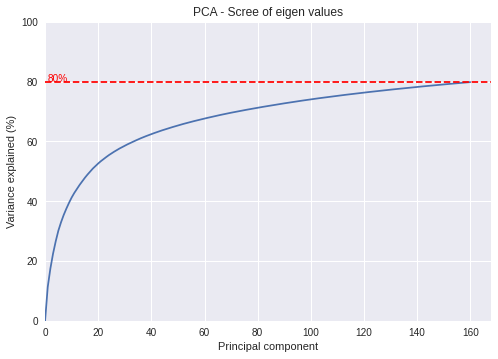

In [17]:
# Displaying the scree plot
eigen_val = pca_model.explainedVariance.cumsum()

# Setup the figure
sns.lineplot(x=[i for i in range(n_comp + 1)], 
             y=np.insert(eigen_val, 0, 0) * 100)
plt.title('PCA - Scree of eigen values')
plt.xlabel('Principal component')
plt.ylabel('Variance explained (%)')
plt.ylim(0, 100)
plt.xlim(left=0)
plt.axhline(y=80, color='red', linestyle='--')
plt.text(1, 80, '80%', c='red')
plt.show()

On sélectionne 160 composantes principales, ce qui correspond à environ 80% de la variance totale expliquée. Lorsque le volume des données augmente, il faudra adapter le nombre de composantes principales.

## 2.3 Export et sauvegarde du résultat de la réduction de dimension

On commence par créer les labels à partir des catégories des fruits.

In [18]:
# 2.3 Export and save the result of the dimension reduction
# Creating the labels
indexer = StringIndexer(inputCol='category', outputCol='label')
indexer_model = indexer.fit(reduced_features_df)
preprocessed_df = indexer_model.transform(
    reduced_features_df).select(['path',
                                 'category',
                                 'label',
                                 'features',
                                 'reduced_features'])
preprocessed_df.show(10)

+--------------------+----------+-----+--------------------+--------------------+
|                path|  category|label|            features|    reduced_features|
+--------------------+----------+-----+--------------------+--------------------+
|file:/home/ubuntu...|cucumber_3| 16.0|[13.015601, 0.412...|[22.0563302472823...|
|file:/home/ubuntu...|cucumber_3| 16.0|[11.227732, 2.544...|[29.5416442253633...|
|file:/home/ubuntu...|cucumber_3| 16.0|[11.6619835, 0.0,...|[22.6577782287306...|
|file:/home/ubuntu...|cucumber_3| 16.0|[8.882978, 0.2665...|[24.5181085607209...|
|file:/home/ubuntu...|cucumber_3| 16.0|[9.96269, 0.0, 4....|[25.4586141102722...|
|file:/home/ubuntu...|cucumber_3| 16.0|[10.606714, 2.678...|[30.5661088496701...|
|file:/home/ubuntu...|cucumber_3| 16.0|[12.147586, 3.187...|[28.4814759125390...|
|file:/home/ubuntu...|cucumber_3| 16.0|[9.426011, 0.0, 3...|[26.4833055403674...|
|file:/home/ubuntu...|cucumber_3| 16.0|[11.3854265, 1.58...|[26.6687687285814...|
|file:/home/ubun

On convertit ensuite le Spark dataframe en Pandas dataframe.

In [19]:
# Converting the Spark dataframe to Pandas dataframe
dataset_df = preprocessed_df.toPandas()
dataset_df

,path,category,label,features,reduced_features
0,file:/home/ubuntu/code/fruits-360-original-siz...,cucumber_3,16.0,"[13.01560115814209, 0.41211116313934326, 5.602...","[22.05633024728239, -15.719720020497427, -5.93..."
1,file:/home/ubuntu/code/fruits-360-original-siz...,cucumber_3,16.0,"[11.227731704711914, 2.5448858737945557, 3.976...","[29.541644225363346, -15.400400913634435, -5.0..."
2,file:/home/ubuntu/code/fruits-360-original-siz...,cucumber_3,16.0,"[11.661983489990234, 0.0, 4.2941508293151855, ...","[22.657778228730677, -14.577185472140187, -6.5..."
3,file:/home/ubuntu/code/fruits-360-original-siz...,cucumber_3,16.0,"[8.882978439331055, 0.26657044887542725, 3.846...","[24.518108560720957, -13.479907185890998, -6.7..."
4,file:/home/ubuntu/code/fruits-360-original-siz...,cucumber_3,16.0,"[9.962690353393555, 0.0, 4.3142571449279785, 0...","[25.458614110272258, -14.112061471782352, -5.5..."
...,...,...,...,...,...
6226,file:/home/ubuntu/code/fruits-360-original-siz...,apple_braeburn_1,2.0,"[7.170302867889404, 9.89063549041748, 3.272537...","[-14.327274754175418, -15.760397921915668, 1.0..."
6227,file:/home/ubuntu/code/fruits-360-original-siz...,apple_braeburn_1,2.0,"[8.492012023925781, 7.83235502243042, 3.993443...","[-15.643271121386684, -13.454551203065453, 0.7..."
6228,file:/home/ubuntu/code/fruits-360-original-siz...,apple_braeburn_1,2.0,"[8.959314346313477, 8.400957107543945, 4.88875...","[-13.58671901679626, -13.959422461654626, -0.2..."
6229,file:/home/ubuntu/code/fruits-360-original-siz...,apple_braeburn_1,2.0,"[7.764952182769775, 10.522821426391602, 4.6634...","[-15.965334679626665, -14.993592026989704, -0...."


In [20]:
# Save the Pandas dataframe
dataset_df.to_csv('P8_pretraitement.csv', index=False)

# Conclusion

- L’architecture Big Data présentée permet d’effectuer le passage à l’échelle pour le traitement des données massives.
- Lors du passage à l'échelle, il faut adapter le nombre de composantes principales en fonction du volume des données et du pourcentage de variance expliquée souhaité.
- Pour résoudre les problématiques de complexité en mémoire et en temps de calcul, il faut :
  - Adapter les infrastructures (par exemple choisir une instance avec plus de RAM et plus de processeurs, utiliser un cluster de plusieurs serveurs ou machines, etc.).
  - Adapter les algorithmes à la large échelle ou Large Scale Learning (utiliser les approches stochastiques, installer TensorFlow-GPU ou utiliser TensorFlow-TPU, etc.).
- Il est possible de suivre les jobs Spark avec l’interface graphique Spark Web UI.